In [1]:
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import networkx as nx
import numpy as np
from unionfind import utils
import matplotlib.pyplot as plt

### Generate surface code decoding graph 
- with arbitrary `code_distance` and `num_rounds`
- **phenomenonological noise model**

In [28]:
d = 5
r = 3
p_data = 0.01
p_meas = 0.05
g = utils.gene_surf_decoding_graph(d, r, p_data, p_meas)

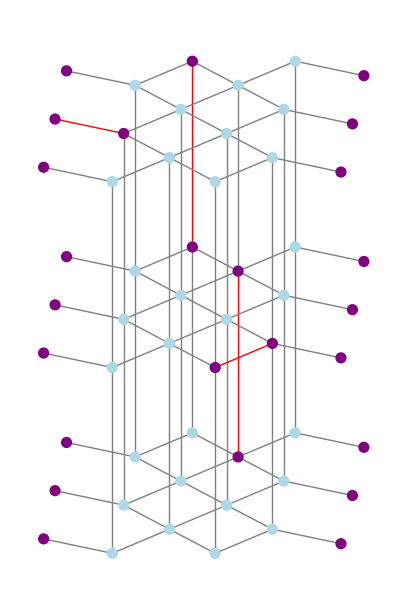

In [29]:
_ = utils.visualize_surf_decoding_graph(g, d, r)

### Comparison of `DistSurfDecoder`, `GPUSurfDecoder` and `MonoSurfDecoder`

#### Distributed decoding

In [30]:
import unionfind.distributed
import importlib
importlib.reload(unionfind.distributed)

decoder_dist = unionfind.distributed.DistSurfDecoder(g, d, r)

In [31]:
decoder_dist.decode()

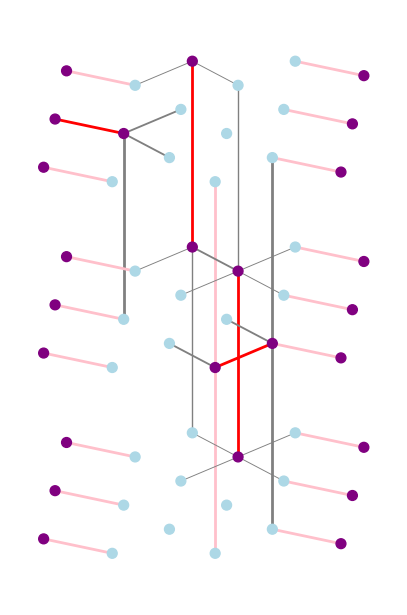

In [32]:
_ = decoder_dist.visualize_result_graph()

In [33]:
decoder_dist.guessed_error, decoder_dist.actual_error

(Pauli('IIIZIIIIIIZIIIIIIIIIIIIII'), Pauli('IIIZIIIIIIZIIIIIIIIIIIIII'))

In [34]:
decoder_dist.logical_error

False

In [35]:
decoder_dist.num_inner_epochs

[5, 9]

In [36]:
# calculate logical error rate
def sim_dist_logical_error_rate(num_iter, d, r):
    from tqdm import tqdm
    e = 0
    for _ in tqdm(range(num_iter)):
        g = utils.gene_surf_decoding_graph(d, r, p_data, p_meas)
        decoder = unionfind.distributed.DistSurfDecoder(g, d, r)
        decoder.decode()
        if decoder.logical_error:
            e += 1
    return e / num_iter / r

In [14]:
sim_dist_logical_error_rate(500, 7, 100)

#### GPU decoding (using DGL library)

In [38]:
import unionfind.gpu
import importlib
import torch

importlib.reload(unionfind.gpu)
decoder_gpu = unionfind.gpu.GPUSurfDecoder(g, d, r)

In [39]:
# has GPU?
torch.cuda.is_available()

False

In [40]:
decoder_gpu.decode()

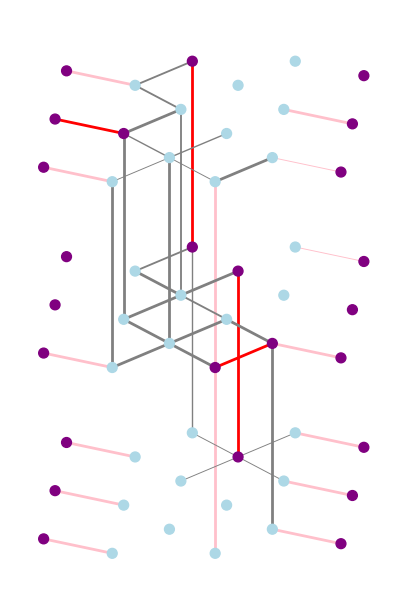

In [41]:
_ = decoder_gpu.visualize_result_graph()

In [43]:
decoder_gpu.guessed_error, decoder_gpu.actual_error 

(Pauli('IIIZIIIIIIZIIIIIIIIIIIIII'), Pauli('IIIZIIIIIIZIIIIIIIIIIIIII'))

In [44]:
decoder_gpu.logical_error

False

In [47]:
# calculate logical error rate
def sim_gpu_logical_error_rate(num_iter, d, r):
    from tqdm import tqdm
    e = 0
    for _ in tqdm(range(num_iter)):
        g = utils.gene_surf_decoding_graph(d, r, p_data, p_meas)  # change d and r
        decoder = unionfind.gpu.GPUSurfDecoder(g, d, r)
        decoder.decode()
        if decoder.logical_error:
            e += 1
    return e / num_iter / r

In [49]:
# if there is no GPU, DGL-version distributed decoder has no advantage
sim_gpu_logical_error_rate(500, 7, 100)

#### Monolithic decoding

In [50]:
import unionfind.monolithic
import importlib
importlib.reload(unionfind.monolithic)

decoder_mono = unionfind.monolithic.MonoSurfDecoder(g, d, r)

In [51]:
decoder_mono.decode()

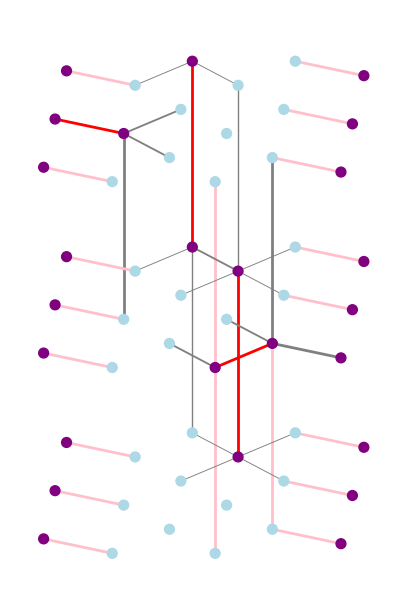

In [52]:
_ = decoder_mono.visualize_result_graph()

In [53]:
decoder_mono.num_epochs

2

In [54]:
# calculate logical error rate
def sim_mono_logical_error_rate(num_iter, d, r):
    from tqdm import tqdm
    e = 0
    for _ in tqdm(range(num_iter)):
        g = utils.gene_surf_decoding_graph(d, r, p_data, p_meas)  # change d and r
        decoder = unionfind.monolithic.MonoSurfDecoder(g, d, r)
        decoder.decode()
        if decoder.logical_error:
            e += 1
    return e / num_iter / r


In [55]:
sim_mono_logical_error_rate(500, 7, 100)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [10:26<00:00,  1.25s/it]


0.00364

### Analysis in terms of [FPGA paper](https://arxiv.org/abs/2301.08419)
- $p_{data} = 0.001$
- $p_{meas} = 0.001$
- r = d
- Phenomenological noise model
- *typical result: $d=21$, $\tau=11.5$ ns per measurement round*

In [5]:
from unionfind import distributed, utils
from tqdm import tqdm
    

---

In [6]:
d = 21
r = d
p_data = 0.001
p_meas = 0.001

In [8]:
num_epochs = []
num_inner_epochs = []

trials = 100
g = utils.gene_surf_decoding_graph(d, r, p_data, p_meas)
for _ in tqdm(range(trials)):
    utils.sample_errors(g) # resample errors
    decoder = distributed.DistSurfDecoder(g, d, r)
    decoder.decode()
    num_epochs.append(decoder.num_epochs)
    num_inner_epochs.append(np.mean(decoder.num_inner_epochs))
    

100%|██████████| 100/100 [02:31<00:00,  1.51s/it]


In [12]:
num_clocks = 4 * np.array(num_inner_epochs) * np.array(num_epochs) + np.array(num_epochs)
period = 2  # 2 ns means 500 MHz
times = num_clocks * period

In [18]:
print('decoding rate: {:.4f} ns per measurement round'.format(times.mean() / d))

decoding rate: 4.0267 ns per measurement round


---

In [22]:
def avg_decoding_latency(d, p_data, p_meas, trials=100, period=2):
    """
    :param d: code distance
    :param trials: number of trials
    :param period: corresponding to FPGA clock frequency
    """
    num_epochs = []
    num_inner_epochs = []

    g = utils.gene_surf_decoding_graph(d, r, p_data, p_meas)
    for _ in tqdm(range(trials)):
        utils.sample_errors(g) # resample errors
        decoder = distributed.DistSurfDecoder(g, d, r)
        decoder.decode()
        num_epochs.append(decoder.num_epochs)
        num_inner_epochs.append(np.mean(decoder.num_inner_epochs))
    num_clocks = 4 * np.array(num_inner_epochs) * np.array(num_epochs) + np.array(num_epochs)
    times = num_clocks * period
    return times.mean() / d

In [23]:
p_data = 0.001
p_meas = 0.001
latencies = []
distances = list(range(3, 22, 2))
for d in distances:
    print('emulating latency for distance {}'.format(d))
    latency = avg_decoding_latency(d, p_data, p_meas)
    latencies.append(latency)

emulating latency for distance 3


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 81.42it/s]


emulating latency for distance 5


100%|██████████| 100/100 [00:04<00:00, 22.17it/s]


emulating latency for distance 7


100%|██████████| 100/100 [00:09<00:00, 10.63it/s]


emulating latency for distance 9


100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


emulating latency for distance 11


100%|██████████| 100/100 [00:30<00:00,  3.23it/s]


emulating latency for distance 13


100%|██████████| 100/100 [00:44<00:00,  2.25it/s]


emulating latency for distance 15


100%|██████████| 100/100 [01:02<00:00,  1.59it/s]


emulating latency for distance 17


100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


emulating latency for distance 19


100%|██████████| 100/100 [01:44<00:00,  1.05s/it]


emulating latency for distance 21


100%|██████████| 100/100 [02:12<00:00,  1.32s/it]


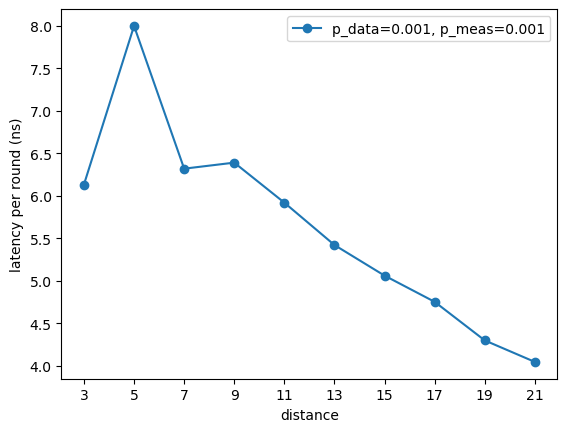

In [28]:
plt.plot(distances, latencies,'o-', label='p_data={}, p_meas={}'.format(p_data, p_meas))
plt.legend()
plt.xlabel('distance')
plt.ylabel('latency per round (ns)')
plt.xticks(distances)
plt.show()

By comparing the above result with the $p=0.001$ curve of the following figure, we can see the "curve trendy" coincide with each other. The two series of latency values have a 3x difference (e.g., `11.5 ns` v.s. `4 ns`).

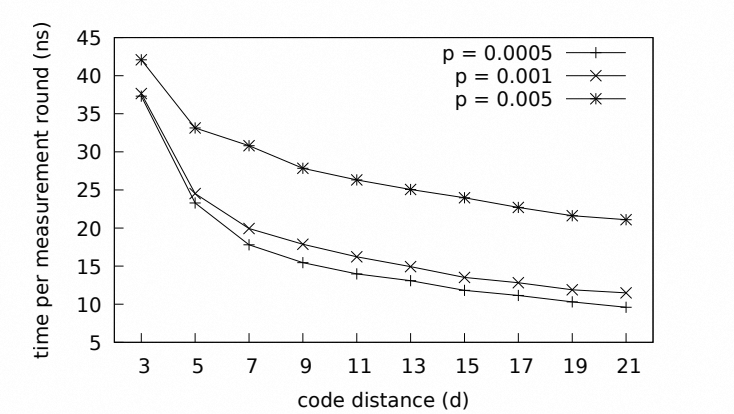